# Knowledge-Graph-Based Retrieval Augmented Generation for FSU Search

#### The problem
The search functionality on fsu.edu sites is fragmented and cumbersome. Its functionality reflects none of the recent advancements in natural language processing - specifically, Large Language Models and the ability to intelligently and naturally respond to queries.

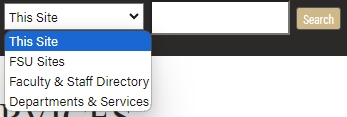

We seek to do two main modifications:
1. combine these searches into one, providing only an option to limit to the current site.
2. Wield the power of Large Language Models to allow for conversational or question/answer capability using direct information from FSU's databases and websites.

It is with these requirements that we present a possible solution:
**Combining the power of knowledge graphs, a powerful way to represent relational data, and Retrieval Augmented Generation (RAG), a technique for informing Language Models with real data, we can make a powerful pairing that allows for users to get information about FSU faculty, staff, departments, buildings, events, classes, and more.**

let's explore how we do this.

#### Making the knowledge graph

%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs pandas

In [16]:
from dotenv import load_dotenv
import os

from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.documents.base import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple, List
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.graphs import Neo4jGraph
from langchain.text_splitter import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.runnables import RunnableParallel, RunnablePassthrough


# Warning control
import warnings
warnings.filterwarnings("ignore")

##### Reading in Faculty and Staff Data

In [3]:
# Load from environment
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
# NEO4J_DATABASE = os.getenv('AURA_INSTANCEID')

##### Initializing the Knowledge Graph

In [6]:
# Connect to the knowledge graph instance using LangChain
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)


##### Crawling fsu.edu

In [8]:
NEW_RUN = False #setting this to true will overrite any previously made datafile and will take about 5 minutes.

# already done so importing json file instead
if not NEW_RUN:
    import json
    datafile = "GFMDSpider_output.json"
    try:
        with open(datafile) as f:
            data = json.load(f)
    except:
        raise
else:
    from Spiders.HTMLtoMarkdownSpider import HTMLtoMarkdownSpider
    fsu_edu_spider = HTMLtoMarkdownSpider("https://www.fsu.edu/")
    data = fsu_edu_spider.run()



In [29]:
# Define chunking strategy
main_site_url = "https://www.fsu.edu/"
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=24)
website = [f"{"Website Homepage" if key == main_site_url else "Webpage"}: {key}[ content: {data[key]['content']}\n links in page: {data[key]['links']}]" for key in data.keys()]
website = "\n".join(website)
split_website = text_splitter.split_text(website)
website_contents = [Document(page_content= item) for item in split_website]


# website= text_splitter.split_text(doc_contents)
print(website_contents)

[Document(page_content="Webpage: https://www.fsu.edu[ content: # [Florida State University](https://www.fsu.edu/)\n\nAuthor: Florida State University\nContent:\n### [Admissions: Apply Now](http://admissions.fsu.edu/)\n\n[UNDERGRADUATE](https://admissions.fsu.edu/undergradapp/)\n\n[GRADUATE](https://admissions.fsu.edu/gradapp/)\n\n---\n\n#### Related Links\n\n-   [Career Center](http://www.career.fsu.edu/)\n-   [Course Catalog](http://registrar.fsu.edu/bulletin/undergraduate/departments/)\n-   [Freshman Finances](http://admissions.fsu.edu/freshman/finances/)\n-   [Graduate Finances](http://admissions.fsu.edu/graduate/finances/)\n-   [Housing](https://housing.fsu.edu/)\n\n-   [Majors](http://admissions.fsu.edu/majors/)\n-   [Photos & Video](http://admissions.fsu.edu/media/)\n-   [Student Life](http://admissions.fsu.edu/studentlife/)\n-   [Visit FSU](http://visit.fsu.edu/)\n\n##### FSU: This place is special\n\n### Academic Calendar\n\n[View full academic calendar](https://calendar.fsu.ed

##### Updating Knowledge Graph

In [30]:
llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125") # gpt-4-0125-preview occasionally has issues
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(website_contents)
kg.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

#### Visualizing the Graph

In [31]:
# directly show the graph resulting from the given Cypher query
default_cypher = "MATCH (s)-[r:!MENTIONS]->(t) RETURN s,r,t LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

#### Vector Embeddings

In [32]:
vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

#### Graph retrieval

In [52]:
# Retriever

kg.query(
    "CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

# Extract entities from text
class Entities(BaseModel):
    """Identifying information about entities."""

    names: List[str] = Field(
        ...,
        description="All the person, organization, or business entities that appear in the text. Including ongoing projects, programs, departments, ongoing news, and events.",
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are extracting All the person, organization, or business entities that appear in the text. Including ongoing projects, programs, departments, ongoing news, and events from the text.",
        ),
        (
            "human",
            "Use the given format to extract information from the following "
            "input: {question}",
        ),
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

#### Let's ask a question

In [53]:
entity_chain.invoke({"question": "What do you know about Florida State University?"}).names

['Florida State University']

In [54]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

# Fulltext index query
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = kg.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node,score
            CALL {
              MATCH (node)-[r:!MENTIONS]->(neighbor)
              RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
              UNION
              MATCH (node)<-[r:!MENTIONS]-(neighbor)
              RETURN neighbor.id + ' - ' + type(r) + ' -> ' +  node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)},
        )
        result += "\n".join([el['output'] for el in response])
    return result

In [71]:
print(structured_retriever("Departments"))

Florida State University - HAS_LINK -> Admissions: Apply Now
Florida State University - HAS_LINK -> Undergraduate
Florida State University - HAS_LINK -> Graduate
Florida State University - HAS_LINK -> Career Center
Florida State University - HAS_LINK -> Course Catalog
Florida State University - HAS_LINK -> Freshman Finances
Florida State University - HAS_LINK -> Graduate Finances
Florida State University - HAS_LINK -> Housing
Florida State University - HAS_LINK -> Majors
Florida State University - HAS_LINK -> Photos & Video
Florida State University - HAS_LINK -> Student Life
Florida State University - HAS_LINK -> Visit Fsu
Florida State University - HAS_LINK -> Academic Calendar
Florida State University - RECOGNIZES -> Student Stars
Florida State University - HAS_INITIATIVE -> Know More
Florida State University - CONTRIBUTES_TO -> Florida State'S Economic Impact
Florida State University - CONTRIBUTES_TO -> Economic Impact
Florida State University - CONTRIBUTES_TO -> State
Florida State

In [67]:
def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    print(final_data)
    return final_data

RAG Chain

In [57]:
# Condense a chat history and follow-up question into a standalone question
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""  # noqa: E501
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with the follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # Condense follow-up question and chat into a standalone_question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | ChatOpenAI(temperature=0)
        | StrOutputParser(),
    ),
    # Else, we have no chat history, so just pass through the question
    RunnableLambda(lambda x : x["question"]),
)

Creating a usable Prompt for the LLM

In [58]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

In [61]:
chain.invoke({"question": "What is FSU's relationship with the Seminole Tribe?"})

Search query: What is FSU's relationship with the Seminole Tribe?


"Florida State University has a collaborative friendship with the Seminole Tribe of Florida, honoring their ancestral lands and using the Seminole name with consistency to the Tribe's values. The Tribe works closely with FSU on various issues and representatives serve as dignitaries at university functions."

In [68]:
chain.invoke(
    {
        "question": "How did they come to an agreement?",
        "chat_history": [("question: What is FSU's relationship with the Seminole Tribe?", "answer: Florida State University has a collaborative friendship with the Seminole Tribe of Florida, honoring their ancestral lands and using the Seminole name with consistency to the Tribe's values. The Tribe works closely with FSU on various issues and representatives serve as dignitaries at university functions.")]
    }
)

Search query: How did Florida State University come to an agreement with the Seminole Tribe?


"Florida State University and the Seminole Tribe of Florida came to an agreement through a collaborative friendship, honoring the Tribe's ancestral lands and values. The Tribe works closely with FSU on various issues and representatives serve as dignitaries at university functions."